In [120]:
import pandas as pd
import os
import re
from typing import List
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
def split_filename(s):
    match = re.match(r'([^-]+-[^-]+)-(.*)', s)
    if match:
        return match.groups()
    else:
        return s, ''
    
def freq_check(structure_id, frequency_column):
    pattern = r'-ts-(?!ref)'
    if re.search(pattern, structure_id):
        try:
            return float(frequency_column) < -5.0 # detection threshold
        except ValueError:
            print(f"Frequency error in {structure_id}")
            return False
    else:
        try:
            float(frequency_column)
            print(f"Frequency error in {structure_id}")
            return False 
        except ValueError:
            return True
        
def get_energy(df, structure_name):
    return df[df['structure'] == structure_name]['qh-G(T)_SPC'].values[0]

def get_reference_gibbs_energy(df, structure_name):
    return df[df['label_name'] == structure_name]['reference_gibbs'].values[0]

def get_reactant_energy(structure_name):
    if "naphh" in structure_name:
        structure_name = "naphh"
    return base_reactants_df[base_reactants_df['structure'] == structure_name]['qh-G(T)_SPC'].values[0]

def get_ligand_energy(df, ligand):
    return df[(df['group'] == ligand) & (df['structure'] == '54-lig')]['qh-G(T)_SPC'].values[0]

def get_reference_energy(df, ligand):
    return df[(df['structure'] == '00-lpdoh2') & (df['group'] == ligand)]['equalized_gibbs'].values[0]

def get_precatalyst_energy(df, ligand):
    return (get_energy(df, "00-lpdoh2") - 2*get_ligand_energy(ligands_df, ligand))/2

def equalize_reference(row, ligand):
    if row['structure'] == '00-lpdoh2':
        return row['qh-G(T)_SPC'] / 2 + 2*get_energy(base_reactants_df, 'naphboh2') + get_energy(base_reactants_df, 'h2o') + get_ligand_energy(ligands_df, ligand)
    
    elif row['structure'] in ['01-rxt', '02-ts-rxt-c1', '03-c1', '04-ts-c1-c2', '05-c2',
                            '12-ts-rxt-t1', '13-t1', '14-ts-t1-t2', '15-t2', 
                            '26-ts-t2-xa',  '29-ts-t2-xb',  
                            '32-ts-rxt-ya', '33-ya', '34-ts-ya-c1', '55-c2alt']:
        return row['qh-G(T)_SPC'] + get_energy(base_reactants_df, 'h2o') + get_energy(base_reactants_df, 'naphboh2') + get_ligand_energy(ligands_df, ligand)
    
    elif row['structure'] in ['06-c2-h2o', '07-ts-c2-c3', '08-c3-boh3',
                            '16-t2-h2o', '17-ts-t2-t3', '18-t3-boh3',
                            '22-c5', '23-ts-c5-c6', '24-t5', '25-ts-t5-t6',
                            '35-ts-rxt-yb', '36-yb', '37-ts-yb-c1',
                            ]:
        return row['qh-G(T)_SPC'] + get_energy(base_reactants_df, 'naphboh2') + get_ligand_energy(ligands_df, ligand)
    
    elif row['structure'] in ['27-xa', '30-xb',]:
        return row['qh-G(T)_SPC'] + get_energy(base_reactants_df, 'boh3') + get_energy(base_reactants_df, 'h2o') + get_ligand_energy(ligands_df, ligand) + get_energy(base_reactants_df, 'naphboh2')

    elif row['structure'] in ['28-ts-xa-t3', '31-ts-t3-xb',]:
        return row['qh-G(T)_SPC'] + get_energy(base_reactants_df, 'naphboh2') + get_energy(base_reactants_df, 'boh3') + get_ligand_energy(ligands_df, ligand)

    elif row['structure'] in ['09-c3', '10-ts-c3-c4', '11-c4',
                            '19-t3', '20-ts-t3-t4', '21-t4',]:
        return row['qh-G(T)_SPC'] + get_energy(base_reactants_df, 'boh3') + get_energy(base_reactants_df, 'naphboh2') + get_ligand_energy(ligands_df, ligand)
    
    elif row['structure'] in ['38-t2-lig', '39-ts-t2-t2p', '40-t2p-boh3',]:
        return row['qh-G(T)_SPC'] + get_energy(base_reactants_df, 'h2o') + get_energy(base_reactants_df, 'naphboh2')
    
    elif row['structure'] in ['41-t2p']:
        return row['qh-G(T)_SPC'] + get_energy(base_reactants_df, 'boh3') + get_energy(base_reactants_df, 'h2o') + get_energy(base_reactants_df, 'naphboh2')
    
    else:
        print(f"Messed up {row}")
        return "huh"

def get_main_microkinetics_transformations(type_name="main"):
    int_list = ['00-lpdoh2', '01-rxt', '03-c1', '05-c2', '09-c3', '11-c4', '13-t1', '15-t2', '19-t3', '21-t4']
    ts_list = ['02-ts-rxt-c1', '04-ts-c1-c2', '07-ts-c2-c3', '10-ts-c3-c4', '12-ts-rxt-t1', '14-ts-t1-t2', '17-ts-t2-t3', '20-ts-t3-t4', ]    
    rxt_pdt_list = ['naphboh2', 'h2o', 'boh3', 'naphh-c', 'naphh-t']
    diffusion_ts_list = ['diffusion-lpdoh2-rxt', 'diffusion-c4-pdt', 'diffusion-t4-pdt']
    xform_dict = {'diffusion-lpdoh2-rxt': ['00-lpdoh2', 'naphboh2', '01-rxt', '', True],
                    '02-ts-rxt-c1': ['01-rxt', '', '03-c1', '', True],
                    '04-ts-c1-c2': ['03-c1', '', '05-c2', '', True],
                    '07-ts-c2-c3': ['05-c2', 'h2o', '09-c3', 'boh3', True],
                    '10-ts-c3-c4': ['09-c3', '', '11-c4', '', True],
                    'diffusion-c4-pdt': ['11-c4', '', 'naphh-c', '00-lpdoh2', True],
                    '12-ts-rxt-t1': ['01-rxt', '', '13-t1', '', True], 
                    '14-ts-t1-t2': ['13-t1', '', '15-t2', '', True],
                    '17-ts-t2-t3': ['15-t2', 'h2o', '19-t3', 'boh3', True],
                    '20-ts-t3-t4': ['19-t3', '', '21-t4', '', True],
                    'diffusion-t4-pdt': ['21-t4', '', 'naphh-t', '00-lpdoh2', True],  
    }
    if type_name == "main":
        pass
    elif type_name == "xa":
        int_list += ['27-xa']
        ts_list += ['26-ts-t2-xa', '28-ts-xa-t3']
        xform_dict['26-ts-t2-xa'] = ['15-t2', '', '27-xa', '', True]
        xform_dict['28-ts-xa-t3'] = ['27-xa', '', '19-t3', '', True]
    elif type_name == "xb":
        int_list += ['30-xb']
        ts_list += ['29-ts-t2-xb', '31-ts-xb-t3']
        xform_dict['29-ts-t2-xb'] = ['15-t2', '', '30-xb', '', True]
        xform_dict['31-ts-xb-t3'] = ['30-xb', '', '19-t3', '', True]
    elif type_name == "xaxb":
        int_list += ['27-xa', '30-xb']
        ts_list += ['26-ts-t2-xa', '28-ts-xa-t3', '29-ts-t2-xb', '31-ts-xb-t3']
        xform_dict['26-ts-t2-xa'] = ['15-t2', '', '27-xa', '', True]
        xform_dict['28-ts-xa-t3'] = ['27-xa', '', '19-t3', '', True]        
        xform_dict['29-ts-t2-xb'] = ['15-t2', '', '30-xb', '', True]
        xform_dict['31-ts-xb-t3'] = ['30-xb', '', '19-t3', '', True]
    elif type_name == "ya":
        int_list += ['33-ya']
        ts_list += ['32-ts-rxt-ya', '34-ts-ya-c1']
        xform_dict['32-ts-rxt-ya'] = ['01-rxt', '', '33-ya', '', True]
        xform_dict['34-ts-ya-c1'] = ['33-ya', '', '03-c1', '', True]
    elif type_name == "yb":
        int_list += ['36-yb']
        ts_list += ['35-ts-rxt-yb', '37-ts-yb-c1']
        xform_dict['35-ts-rxt-yb'] = ['01-rxt', '', '36-yb', '', True]
        xform_dict['37-ts-yb-c1'] = ['36-yb', '', '03-c1', '', True]
    elif type_name == "yayb":
        int_list += ['33-ya', '36-yb']
        ts_list += ['32-ts-rxt-ya', '34-ts-ya-c1', '35-ts-rxt-yb', '37-ts-yb-c1']
        xform_dict['32-ts-rxt-ya'] = ['01-rxt', '', '33-ya', '', True]
        xform_dict['34-ts-ya-c1'] = ['33-ya', '', '03-c1', '', True]
        xform_dict['35-ts-rxt-yb'] = ['01-rxt', '', '36-yb', '', True]
        xform_dict['37-ts-yb-c1'] = ['36-yb', '', '03-c1', '', True]
    elif type_name == "t2p":
        int_list += ['41-t2p']
        ts_list += ['39-ts-t2-t2p']
        rxt_pdt_list += ['pre-catalyst', 'ligand']
        xform_dict['39-ts-t2-t2p'] = ['15-t2', 'ligand', '41-t2p', 'boh3', True]
    else:
        raise("Invalid alternative mechanism")
    
    return int_list, ts_list, rxt_pdt_list, diffusion_ts_list, xform_dict


def get_left_right_barrier_reference_energies(df, xform: List[str]):
    if xform[1] == '':
        energy_l = float(get_energy(df, xform[0]))
    else:
        energy_l = float(get_energy(df, xform[0])) + float(get_energy(df, xform[1]))
    if xform[3] == '':
        energy_r = float(get_energy(df, xform[2]))
    else:
        energy_r = float(get_energy(df, xform[2])) + float(get_energy(df, xform[3]))
        
    return energy_l, energy_r


nice_structure_names = {
    "00-lpdoh2": "[LPd(OH)$_2$]",
    "01-rxt": "RXT",
    "02-ts-rxt-c1": "RXT-C1",
    "03-c1": "C1",
    "04-ts-c1-c2": "C1-C2",
    "05-c2": "C2",
    "06-c2-h2o": "C2 + H$_2$O", 
    "07-ts-c2-c3": "C2-C3",
    "08-c3-boh3": "C3 + B(OH)$_3$", 
    "09-c3": "C3",
    "10-ts-c3-c4": "C3-C4",
    "11-c4": "C4",
    "12-ts-rxt-t1": "RXT-T1",
    "13-t1": "T1",
    "14-ts-t1-t2": "T1-T2",
    "15-t2": "T2",
    "16-t2-h2o": "T2 + H$_2$O", 
    "18-t3-boh3": "T3 + B(OH)$_3$", 
    "17-ts-t2-t3": "T2-T3",
    "19-t3": "T3",
    "20-ts-t3-t4": "T3-T4",
    "21-t4": "T4",
    "22-c5": "C5",
    "23-ts-c5-c6": "C5-C6",
    "24-t5": "T5",
    "25-ts-t5-t6": "T5-T6",
    "26-ts-t2-xa": "T2-XA",
    "27-xa": "XA",
    "28-ts-xa-t3": "XA-T3",
    "29-ts-t2-xb": "T2-XB",
    "30-xb": "XB",
    "31-ts-t3-xb": "T3-XB",
    "32-ts-rxt-ya": "RXT-YA",
    "33-ya": "YA",
    "34-ts-ya-c1": "YA-C1",
    "35-ts-rxt-yb": "RXT-YB",
    "36-yb": "YB",
    "37-ts-yb-c1": "YB-C1",
    "38-t2-lig": "T2 + L",
    "39-ts-t2-t2p": "T2-T2P",
    "40-t2p-boh3": "T2P + B(OH)$_3$",
    "41-t2p": "T2P",
}

proper_names_dict = {'3r-adjohnphos': "AdJohnPhos",
 '3s-adbrettphos': "AdBrettPhos",
 '3k-brettphos': "BrettPhos",
 '3d-cyjohnphos': "CyJohnPhos",
 '3e-cymephos': "CyMePhos",
 '3f-davephos': "DavePhos",
 '3a-iprjohnphos': "(i-Pr)JohnPhos",
 '3q-me4tbuxphos': "Me$_4$tBuXPhos",
 '2k-pad3': "P(Ad)$_3$",
 '2f-pcpt3': "P(Cpt)$_3$",
 '2h-pcy2tbu': "P(Cy)$_2$(t-Bu)",
 '2g-pcy3': "P(Cy)$_3$",
 '3b-phjohnphos': "PhJohnPhos",
 '3c-phdavephos': "PhDavePhos",
 '2e-pipr3': "P(i-Pr)$_3$",
 '2d-potol3': "P(o-tol)$_3$",
 '2c-pph3': "P(Ph)$_3$",
 '2i-ptbu2cy': "P(t-Bu)$_2$(Cy)",
 '2j-ptbu3': "P(t-Bu)$_3$",
 '3i-ruphos': "RuPhos",
 '3g-sphos': "SPhos",
 '3l-tbujohnphos': "JohnPhos",
 '3p-tbubrettphos': "tBuBrettPhos",
 '3n-tbudavephos': "tBuDavePhos",
 '3m-tbumephos': "tBuMePhos",
 '3o-tbuxphos': "tBuXPhos",
 '3j-xphos': "XPhos",
 '3h-ssphos': "sSPhos",    
 '9c-etjohnphos': "EtJohnPhos",
 '9d-mejohnphos': "MeJohnPhos",
 '9a-cbujohnphos': 'CbuJohnPhos',
 '9b-cptjohnphos': 'CptJohnPhos',
 '9e-pcbu3': 'P(Cbu)$_3$',     
 '9f-pcpr3': 'P(Cpr)$_3$',
 '9h-pme3': 'P(Me)$_3$',
 '9g-pet3': 'P(Et)$_3$',
}

In [122]:
df = pd.read_csv("Goodvibes_output.csv", skiprows=23)
df = df.tail(-1)
df = df.head(-1)
df = df[['   Structure', 'qh-G(T)_SPC', 'im']]
df.rename(columns={'   Structure': 'filename'}, inplace=True)

df['filename'] = df.apply(lambda row: row['filename'].split()[1], axis=1) # rcurrent_dfove "  o"
df[['group', 'structure']] = df['filename'].apply(split_filename).apply(pd.Series)
df['freq_status'] = df.apply(lambda row: freq_check(row['structure'], row['im']), axis=1)

In [123]:
base_reactants_df = df[df['group'] == "base-reactants"].copy()
base_catalysis_df = df[df['group'] == "base-catalysis"].copy()
main_df = df[((~df['group'].isin(['base-catalysis', 'base-reactants'])) & (df['structure'] != '54-lig') & (~df['structure'].str.contains('ref')))].copy()
ref_df = df[(df['structure'].str.contains('ref')) | ((df['structure'] == '00-lpdoh2') & (df['group'].isin(['2g-pcy3', '2j-ptbu3', '3d-cyjohnphos', '3l-tbujohnphos'])))].copy()
ligands_df = df[df['structure'] == '54-lig'].copy()

In [124]:
main_df['equalized_gibbs'] = main_df.apply(lambda row: equalize_reference(row, row['group']), axis=1)
main_df['reference_gibbs'] = main_df.apply(lambda row: (row['equalized_gibbs'] - get_reference_energy(main_df, row['group']))*2625.5/4.184, axis=1)

In [125]:
type_name = "main"
diff_barrier = 3.4663630747609946
int_list, ts_list, rxt_pdt_list, diffusion_ts_list, xform_dict = get_main_microkinetics_transformations(type_name=type_name)

for ligand in ['2c-pph3']:
    os.makedirs(f"microkinetics/{type_name}-{ligand}", exist_ok=True)
#for ligand in set(main_df['group'].to_list()):
    current_df = main_df[main_df['group'] == ligand][['structure', 'qh-G(T)_SPC']].copy()
    current_df.loc[current_df['structure'] == '00-lpdoh2', 'qh-G(T)_SPC'] /= 2
    int_df = current_df[(~current_df['structure'].str.contains('ts')) & (current_df['structure'].isin(int_list))].copy()
    
    for rxt in rxt_pdt_list:
        if rxt == "ligand":
            int_df = pd.concat([int_df, pd.DataFrame([{'structure': rxt, 'qh-G(T)_SPC': get_ligand_energy(ligands_df, ligand)}])], ignore_index=True)
        elif rxt == "pre-catalyst":
            int_df = pd.concat([int_df, pd.DataFrame([{'structure': rxt, 'qh-G(T)_SPC': get_precatalyst_energy(current_df, ligand)}])], ignore_index=True)
        else:
            int_df = pd.concat([int_df, pd.DataFrame([{'structure': rxt, 'qh-G(T)_SPC': get_reactant_energy(rxt)}])], ignore_index=True)
    

    int_df.to_csv(f"microkinetics/{type_name}-{ligand}/{type_name}-{ligand}-intermediates.csv", index=False)

    xform_df = pd.DataFrame(columns=['I1', 'I2', 'P1', 'P2', 'Energy', 'Backwards', 'Flag', 'Ref_L', 'Ref_R'])
    xform_df["Backwards"] = xform_df["Backwards"].astype(bool)

    for ts, xform in xform_dict.items():
        energy_l, energy_r = get_left_right_barrier_reference_energies(int_df, xform)

        if ts in diffusion_ts_list:
            ts_energy = max(energy_l, energy_r)
        else:
            ts_energy = get_energy(current_df, ts)

        xform_df = pd.concat([xform_df, pd.DataFrame([{'I1': xform[0], 'I2': xform[1], 'P1': xform[2], 'P2': xform[3], 
                                                    'Energy': ts_energy, 'Backwards': xform[4], 'Flag': ts, 
                                                    'Ref_L': (ts_energy-energy_l)*2625.5/4.184, 
                                                    'Ref_R': (ts_energy-energy_r)*2625.5/4.184,}],
                                                    )])

    xform_df.to_csv(f"microkinetics/{type_name}-{ligand}/{type_name}-{ligand}-transformations.csv", index=False)    


In [126]:
import pandas as pd
import numpy as np
from scipy.interpolate import BPoly
import matplotlib.pyplot as plt

params = {"font.family": "Arial", 'mathtext.default': 'regular'}      
plt.rc('font', size=8)
plt.rcParams.update(params)
plt.rcParams['axes.facecolor'] = 'white'

%matplotlib inline

def interpolate(df, line, num=1000):
    sub_df = df[df['line'] == line]
    x_min = min(sub_df['point'])
    x_max = max(sub_df['point'])
    x_interp = np.linspace(x_min, x_max, num)
    # Turning point at energy minima/maxima
    spline_anchors = [(row['point'], [row['reference_gibbs'], 0]) for _ , row in sub_df.iterrows()]
    #print(spline_anchors)
    spline = BPoly.from_derivatives(xi=sub_df['point'], yi=[[row['reference_gibbs'], 0] for _ , row in sub_df.iterrows()])
    return x_interp, spline(x_interp)

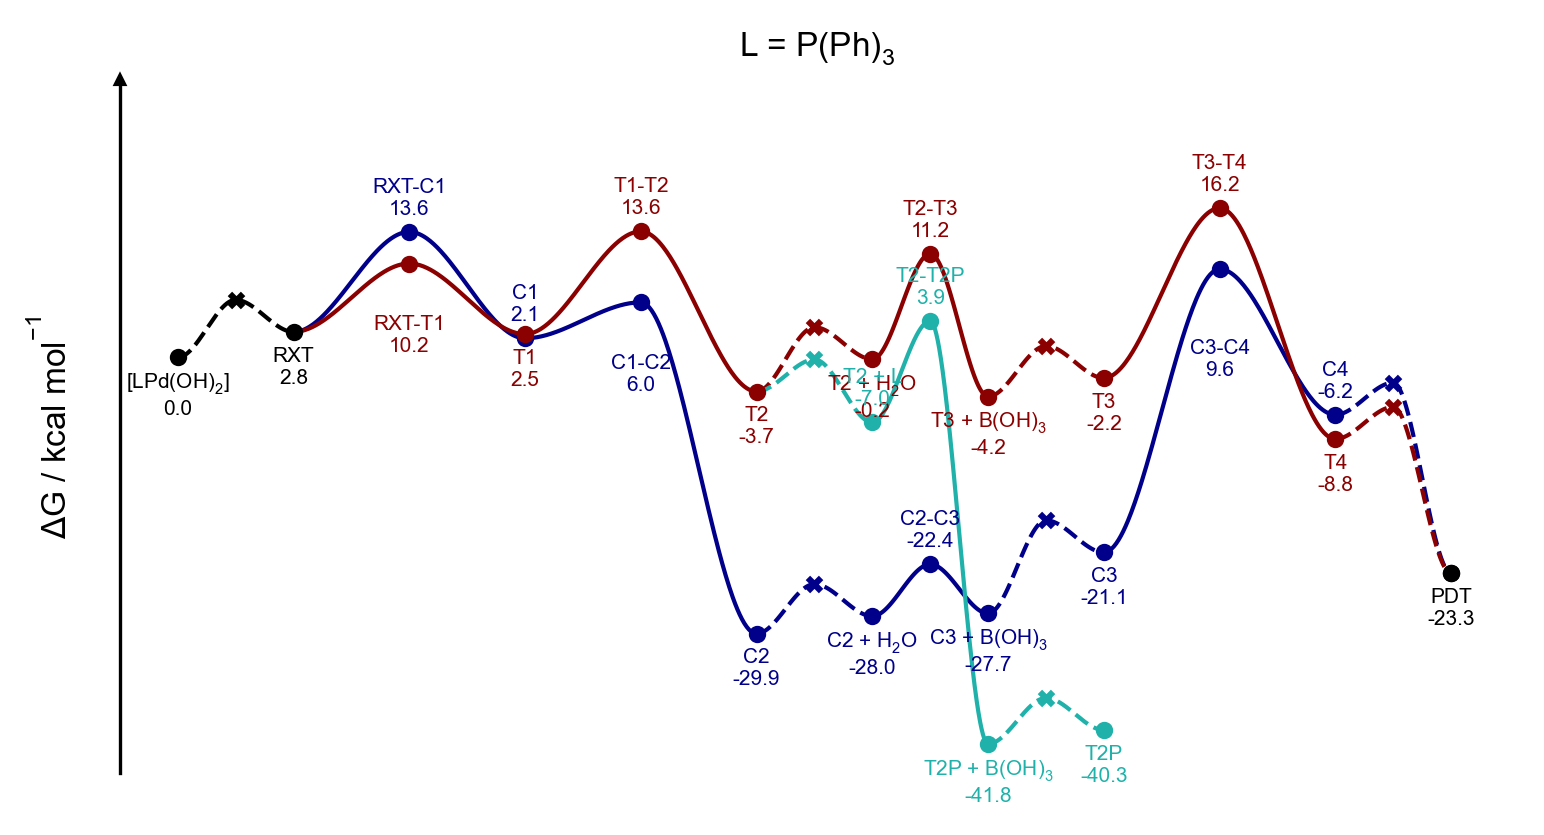

In [132]:
type_name = 't2p'

diffusion_consideration_dict = {"C2 // H$_2$O": ["C2", "C2 + H$_2$O"],
                       "C3 // B(OH)$_3$": ["C3 + B(OH)$_3$", "C3"],
                       "C4-PDT": ['C4', 'PDT'],
                       "T2 // H$_2$O": ["T2", "T2 + H$_2$O"],
                       "T3 // B(OH)$_3$": ["T3 + B(OH)$_3$", "T3"],
                       'T4-PDT': ["T4", "PDT"],
                       "Pd-RXT": ["[LPd(OH)$_2$]", "RXT",],
                       "T2 // L": ["T2", "T2 + L"],
                       "T2P // B(OH)$_3$": ["T2P + B(OH)$_3$", "T2P"]}

pdt_energy = (get_reactant_energy('naphh') + get_reactant_energy('boh3') - get_reactant_energy('naphboh2') - get_reactant_energy('h2o'))*2625.5/4.184

for ligand in ['2c-pph3']:
    os.makedirs(f"microkinetics/{type_name}-{ligand}", exist_ok=True)
    current_df = main_df[main_df['group'] == ligand][['structure', 'reference_gibbs']].copy()
    current_df['label_name'] = current_df.apply(lambda row: nice_structure_names[row['structure']], axis=1)
    current_df = pd.concat([current_df, pd.DataFrame([{'structure': 'pdt', 'reference_gibbs': pdt_energy, 'label_name': 'PDT'}])], ignore_index=True)
    for diffusion, consideration in diffusion_consideration_dict.items():
        energy = max(get_reference_gibbs_energy(current_df, consideration[0]), get_reference_gibbs_energy(current_df, consideration[1]))+diff_barrier
        current_df = pd.concat([current_df, pd.DataFrame([{'structure': 'diffusion', 'reference_gibbs': energy, 'label_name': diffusion}])], ignore_index=True)
    template = pd.read_csv(f"rpd_template_{type_name}.csv")
    template = pd.merge(template, current_df, on='label_name')

    fig, ax = plt.subplots(figsize=(6,3), dpi=300)
    for line in set(template['line'].values):
        curr_line_df = template[template['line'] == line].copy().sort_values(by='point').reset_index(drop=True)
        x_solid, y_solid = interpolate(curr_line_df, line=line)
        for idx, point in curr_line_df.iterrows():
            if point['is_point'] == True:
                ax.scatter(point['point'], point['reference_gibbs'], color=point['point_color'], marker=point['point_marker'], s=10)
            if point['is_TS'] == True:
                # Locate triangle marker index
                idx_0 = np.where(x_solid >= curr_line_df.at[idx-1, 'point'])[0][0]
                idx_1 = np.where(x_solid >= point['point'])[0][0]
                idx_2 = np.where(x_solid >= curr_line_df.at[idx+1, 'point'])[0][0]
                ax.plot(x_solid[idx_0:idx_2], y_solid[idx_0:idx_2], color=curr_line_df['line_color'].values[0], 
                        zorder=-1, linewidth=1, linestyle='--' if point['point_marker'] == 'x' else '-')
            
            if point['is_label'] == True:
                ax.annotate((f"{point['label_name']}" f"\n{point['reference_gibbs']:.1f}"), xy=(point['point'], point['reference_gibbs']), 
                            ha='center', color=point['point_color'], va=point['vertical_alignment'], 
                            fontsize=5, xytext=(point['point'], point['reference_gibbs']+point['vertical_offset']))
            
        
                
    ax.spines[['right', 'top', 'bottom']].set_visible(False)           
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.tick_params(left = False,bottom=False) 
    ax.set_xlim(left=-1)
    ax.plot(-1, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=2)
    ax.set_ylabel("$\Delta G$ / $kcal$ $mol^{-1}$", size=8)
    ax.set_ylim(-45, 30)
    plt.title(f"L = {proper_names_dict[ligand]}", size=8)
    plt.savefig(f"microkinetics/{type_name}-{ligand}/{type_name}-{ligand}.png", facecolor='white', transparent=False, bbox_inches='tight')

In [129]:
template

,line,point,label_name,is_label,is_point,is_TS,vertical_alignment,vertical_offset,line_color,point_color,point_marker,structure,reference_gibbs
0,0,0,[LPd(OH)$_2$],True,True,False,top,-1.5,black,black,o,00-lpdoh2,0.000000
1,0,1,Pd-RXT,False,True,True,top,-1.5,black,black,x,diffusion,6.231484
2,0,2,RXT,True,True,False,top,-1.5,black,black,o,01-rxt,2.765121
3,1,2,RXT,False,False,False,top,-1.5,darkblue,darkblue,o,01-rxt,2.765121
4,2,2,RXT,False,False,False,top,-1.5,darkred,darkred,o,01-rxt,2.765121
5,1,4,RXT-C1,True,True,True,bottom,1.5,darkblue,darkblue,o,02-ts-rxt-c1,13.593426
6,1,6,C1,True,True,False,bottom,1.5,darkblue,darkblue,o,03-c1,2.073605
7,1,8,C1-C2,True,True,True,top,-5.5,darkblue,darkblue,o,04-ts-c1-c2,5.964165
8,1,10,C2,True,True,False,top,-1.5,darkblue,darkblue,o,05-c2,-29.891732
9,1,11,C2 // H$_2$O,False,True,True,top,-1.5,darkblue,darkblue,x,diffusion,-24.532172
